In [1]:
!pip install -q segmentation-models-pytorch --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 191.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 236.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 239.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 241.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 247.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 235.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 226.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is inco

In [2]:
import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver'

In [3]:
import os
import glob
import random
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [4]:
# import sys
# sys.path.append("/kaggle/input/lab-dataset")

# from dataset import LABColorizationWithHintDataset
# print("Dataset class loaded successfully ✅")

In [24]:
import sys
# sys.path.remove('/kaggle/input/lab-seg-dataset')
sys.path.append("/kaggle/input/dataset-stroke")

from dataset import MultiCueStrokeDataset
print("Dataset class loaded successfully ✅")

Dataset class loaded successfully ✅


In [25]:
# =========================
# DataLoader Setup
# =========================

def get_dataloader(image_paths, batch_size=32, num_workers=4):
    dataset = MultiCueStrokeDataset(image_paths, img_size=256, device='cuda')
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        drop_last=True
    )


In [26]:
import os
import glob

# Configuration
TRAIN_FOLDER = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train"
VAL_FOLDER = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val"
IMG_SIZE = 512

subset_class_ids = [
    "n01440764", "n01514859", "n01629819", "n01664065", "n01742172",
    "n01882714", "n01978455", "n02002556", "n02071294", "n02099601",
    "n02104029", "n02112137", "n02123045", "n02165456", "n02206856",
    "n02279972", "n02317335", "n02395406", "n02415577", "n02480495",
    "n02509815", "n02692877", "n02786058", "n02823428", "n02879718",
    "n02966193", "n03047690", "n03126707", "n03179701", "n03255030",
    "n03379051", "n03424325", "n03494278", "n03584829", "n03633091",
    "n03770439", "n03814639", "n03888257", "n03976657", "n04037443",
    "n04118538", "n04552348", "n02113799", "n02391049", "n03478589",
    "n03085013", "n03100240", "n03666591", "n03314780", "n02795169"
]

train_image_paths = []
for class_id in subset_class_ids:
    class_path = os.path.join(TRAIN_FOLDER, class_id)
    if os.path.exists(class_path):
        images = glob.glob(os.path.join(class_path, "*.JPEG"))
        train_image_paths.extend(images)
        
# Gather all validation image paths (.JPEG files) from the flat val folder
val_image_paths = glob.glob(os.path.join(VAL_FOLDER, "*.JPEG"))
len(train_image_paths), len(val_image_paths), train_image_paths[:2], val_image_paths[:2]

(64733,
 50000,
 ['/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_3198.JPEG',
  '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10845.JPEG'],
 ['/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00003485.JPEG',
  '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00021211.JPEG'])

In [27]:
train_dataset = MultiCueStrokeDataset(train_image_paths, img_size=512, device='cuda')
val_dataset = MultiCueStrokeDataset(val_image_paths, img_size=512, device='cuda')

In [40]:
# Example Usage:
train_dataloader = get_dataloader(train_image_paths, batch_size=32, num_workers=4)
val_dataloader = get_dataloader(val_image_paths, batch_size=32, num_workers=4)


In [29]:
print(train_image_paths[:5])
print(type(train_image_paths[0]))


['/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_3198.JPEG', '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10845.JPEG', '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_8421.JPEG', '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_4681.JPEG', '/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_29670.JPEG']
<class 'str'>


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader

def visualize_segment_hint_dataset(dataset, max_images=3, batch_size=1):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    shown = 0

    for inputs, targets in loader:
        L_batch = inputs[:, 0].cpu().numpy()
        hint_ab_batch = inputs[:, 1:3].cpu().numpy()
        target_ab_batch = targets.cpu().numpy()

        for i in range(inputs.shape[0]):
            if shown >= max_images:
                return

            L = (L_batch[i] * 255).astype(np.uint8)
            hint_ab = (hint_ab_batch[i] * 128 + 128).astype(np.uint8).transpose(1, 2, 0)
            target_ab = (target_ab_batch[i] * 128 + 128).astype(np.uint8).transpose(1, 2, 0)

            lab_hint = np.zeros((L.shape[0], L.shape[1], 3), dtype=np.uint8)
            lab_hint[:, :, 0] = L
            lab_hint[:, :, 1:] = hint_ab

            lab_gt = np.zeros_like(lab_hint)
            lab_gt[:, :, 0] = L
            lab_gt[:, :, 1:] = target_ab

            rgb_hint = cv2.cvtColor(lab_hint, cv2.COLOR_LAB2RGB)
            rgb_gt = cv2.cvtColor(lab_gt, cv2.COLOR_LAB2RGB)

            plt.figure(figsize=(15, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(rgb_gt)
            plt.title("Ground Truth RGB")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(rgb_hint)
            plt.title("Stroke Hint RGB")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(L, cmap="gray")
            plt.title("Grayscale L")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            shown += 1


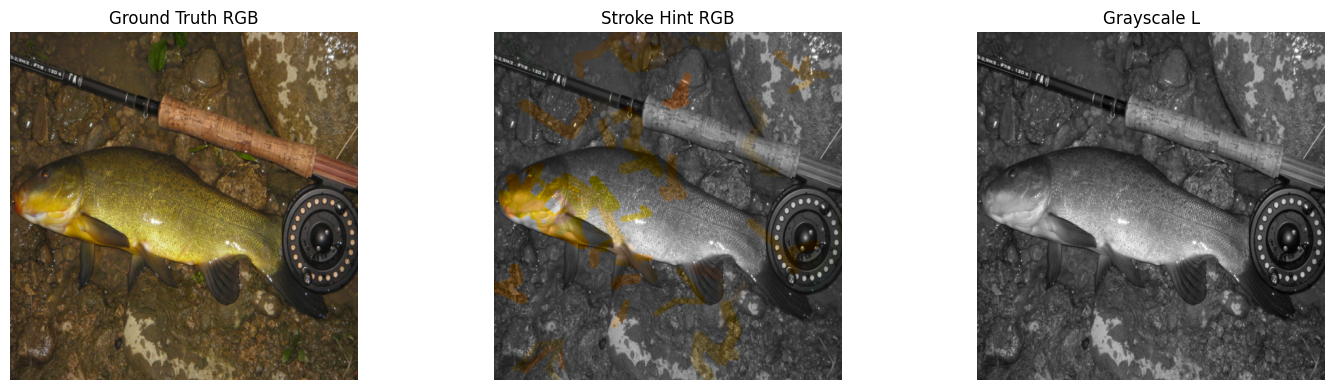

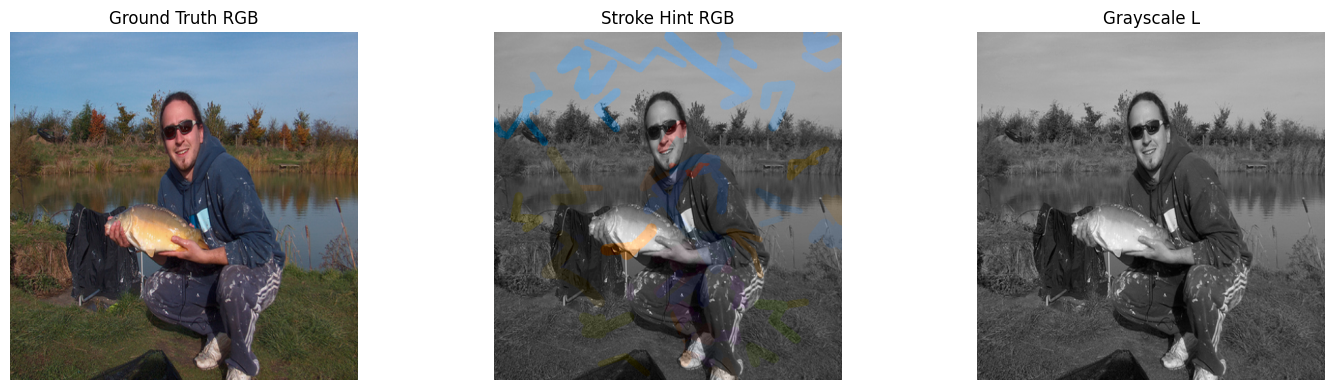

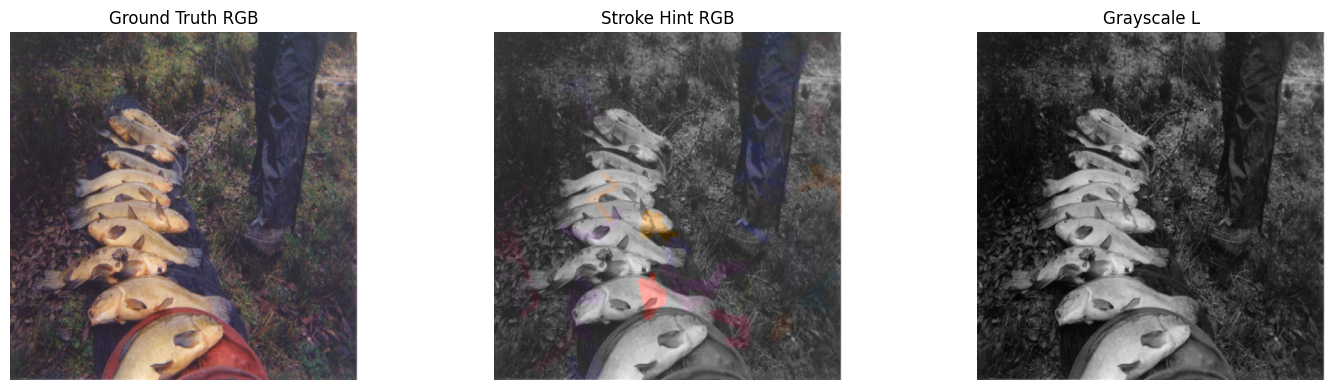

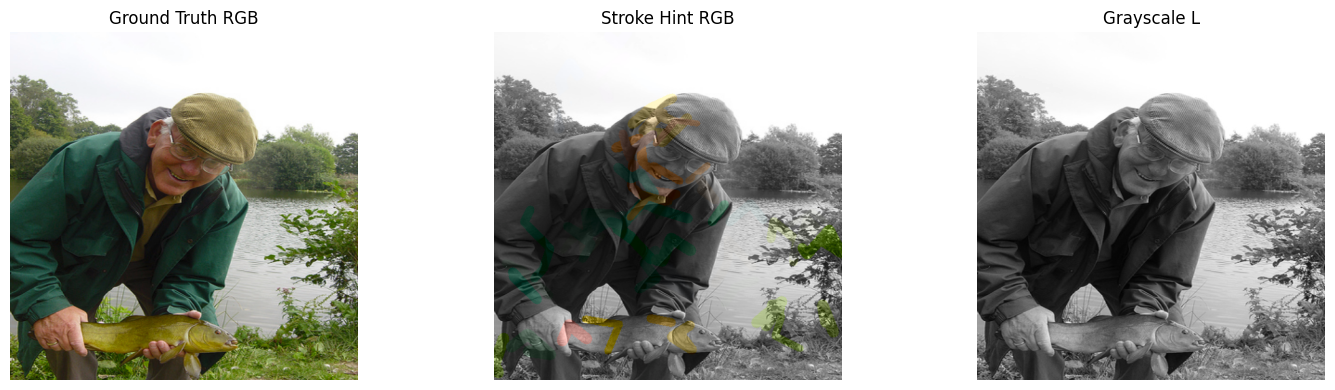

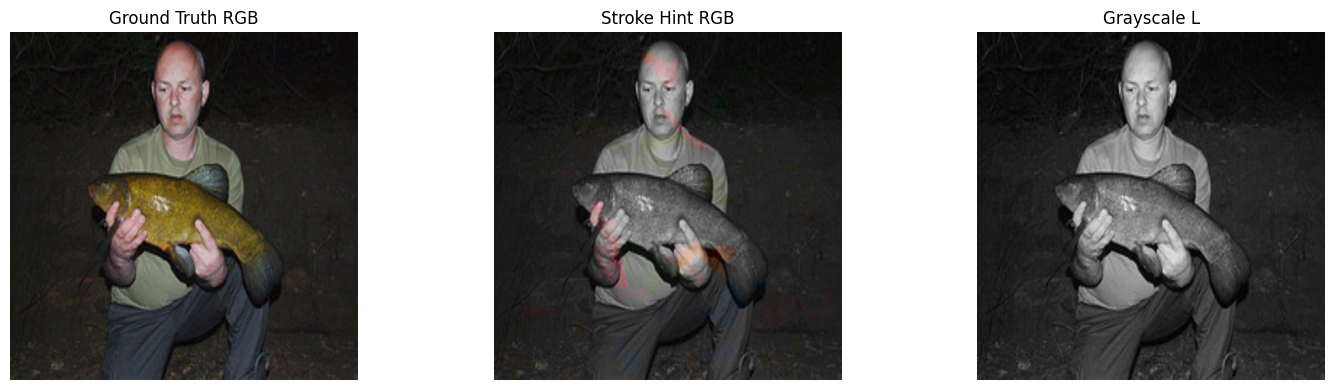

In [31]:
# Visualize input before training
visualize_segment_hint_dataset(train_dataset, max_images=5, batch_size=2)

In [32]:
# =========================
# Pretrained U-Net
# =========================

def get_pretrained_unet(in_channels=3, out_channels=2):
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=in_channels,
        classes=out_channels
    )
    return model



In [35]:
# =========================
# Training and Inference
# =========================
def train_model(model, dataloader, epochs=2, checkpoint_path='checkpoint.pth'):
    model.to('cuda')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # 🔁 Try to resume from checkpoint
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Resuming from epoch {start_epoch}")
    else:
        print("🔁 Starting training from scratch")

    for epoch in range(start_epoch, epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
            inp, target = batch  # Unpack tuple
            inp = inp.to('cuda')
            target = target.to('cuda')

            pred = model(inp)
            loss = criterion(pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"📉 Epoch {epoch+1} Loss: {avg_loss:.4f}")

        # 💾 Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"✅ Checkpoint saved at epoch {epoch+1}")

    return model


In [41]:
model = get_pretrained_unet(in_channels=3, out_channels=2)
trained_model = train_model(model, train_dataloader, epochs=6) 

/tmp/ipykernel_31/2872925140.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


✅ Resuming from epoch 5


Epoch 6: 100%|██████████| 2022/2022 [52:58<00:00,  1.57s/it]


📉 Epoch 6 Loss: 0.0049
✅ Checkpoint saved at epoch 6


In [42]:
import torch
import datetime

# Format: model_YYYYMMDD_HHMMSS.pth
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"model_{timestamp}.pth"

# Save the entire model (architecture + weights)
torch.save(trained_model, filename)
print(f"✅ Entire model saved as {filename}")


✅ Entire model saved as model_20250423_032933.pth


In [48]:
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision.transforms import ToPILImage

def visualize_inference(model, dataset, index=0, device='cuda'):
    model.eval()
    to_pil = ToPILImage()

    # Get sample input
    input_tensor, ab_gt = dataset[index]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # [1, 3, H, W]
    ab_gt = ab_gt.unsqueeze(0).to(device)                # [1, 2, H, W]

    with torch.no_grad():
        pred_ab = model(input_tensor)[0].cpu().numpy()  # [2, H, W]

    # Extract input parts
    L = input_tensor[0, 0].cpu().numpy()          # [H, W]
    hint_ab = input_tensor[0, 1:3].cpu().numpy()  # [2, H, W]
    ab_gt_np = ab_gt[0].cpu().numpy()             # [2, H, W]

    H, W = L.shape

    def lab_to_rgb(L, ab):
        lab = np.zeros((H, W, 3), dtype=np.float32)
        lab[:, :, 0] = L * 100
        lab[:, :, 1:] = ab.transpose(1, 2, 0) * 128
        rgb = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        return np.clip(rgb, 0, 1)

    # Convert all RGB images
    rgb_pred = lab_to_rgb(L, pred_ab)
    rgb_hint = lab_to_rgb(L, hint_ab)
    rgb_gt   = lab_to_rgb(L, ab_gt_np)

    # Plot
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(L, cmap='gray')
    plt.title("Grayscale L")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(rgb_hint)
    plt.title("Stroke Hint")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(rgb_pred)
    plt.title("Predicted Color")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(rgb_gt)
    plt.title("Original RGB")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [50]:
import glob
from torch.utils.data import DataLoader

# Test path
TEST_FOLDER = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/test"
test_image_paths = glob.glob(TEST_FOLDER + "/*.JPEG")[:4]  # Load only first 2 for now

# Create test dataset
test_dataset = MultiCueStrokeDataset(test_image_paths, img_size=256, device='cuda')  # or 'cpu'

# Optional: DataLoader if needed later
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


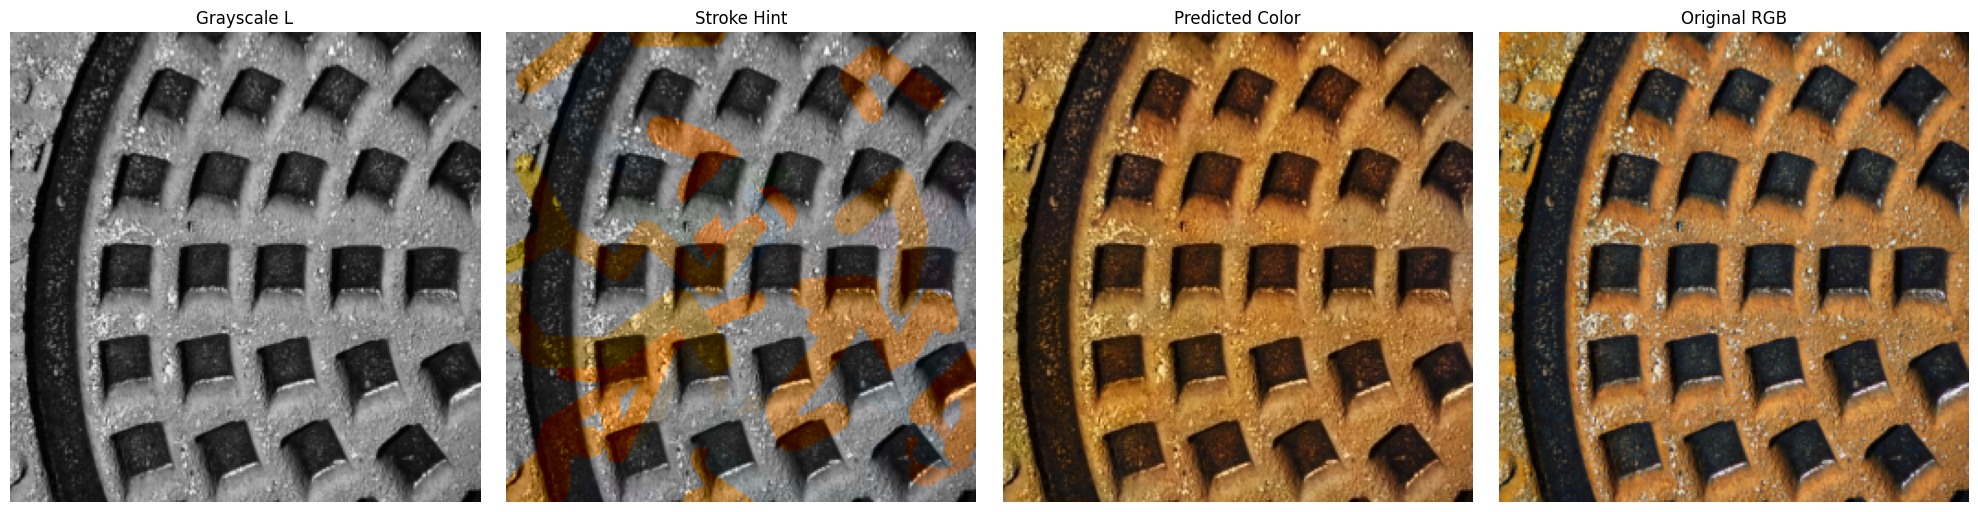

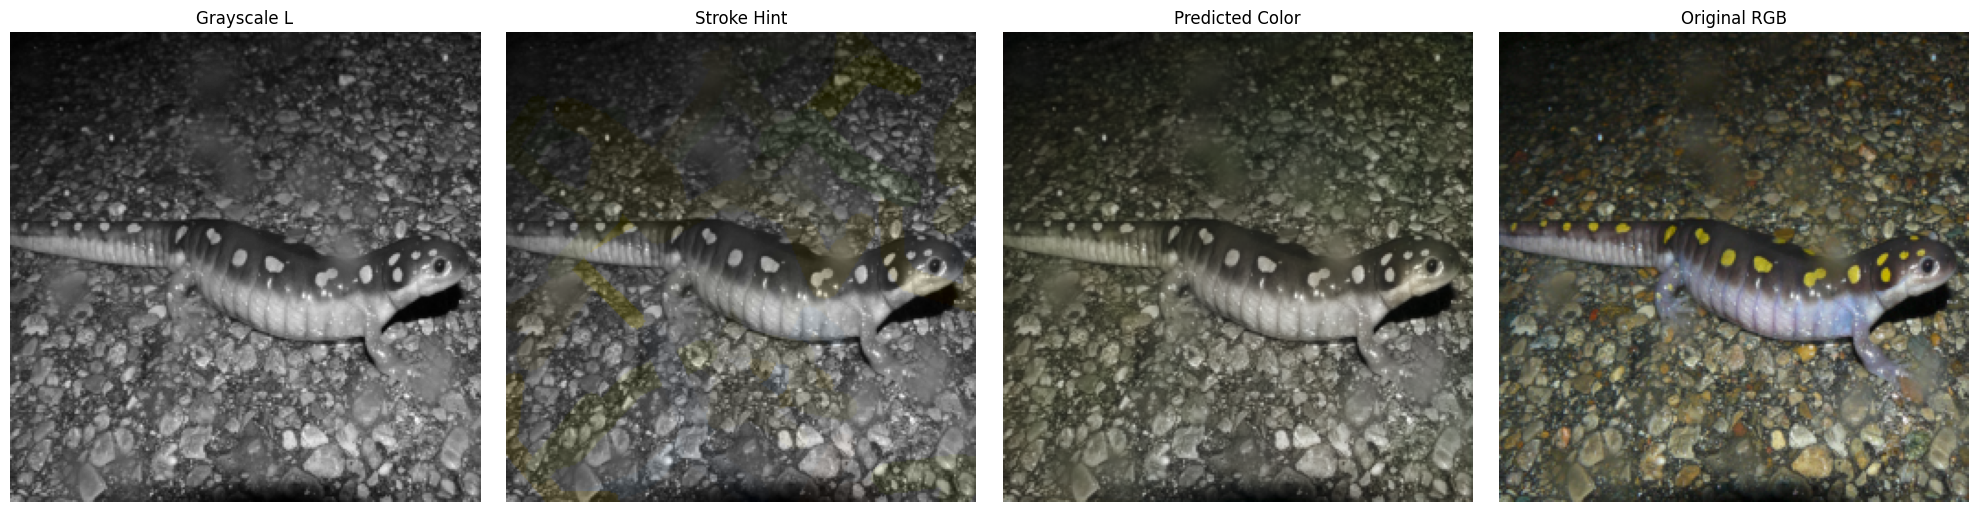

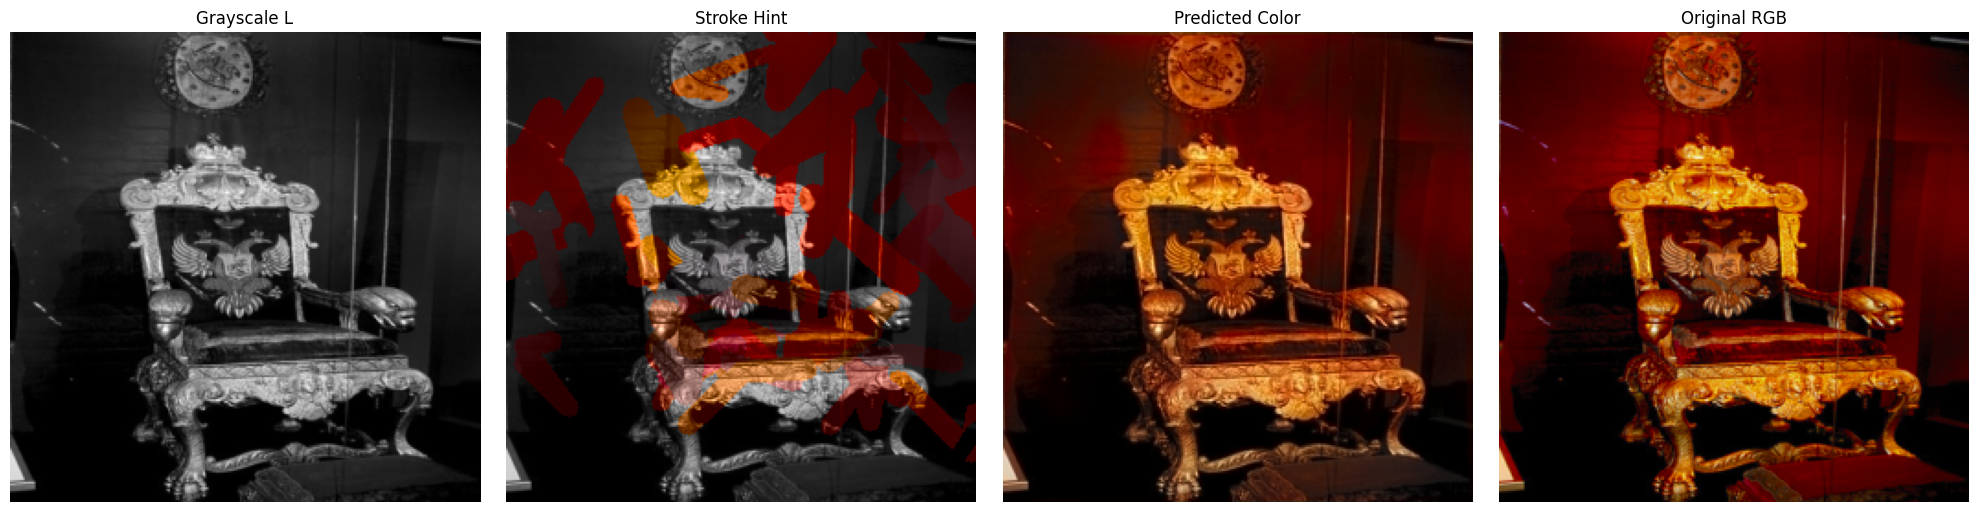

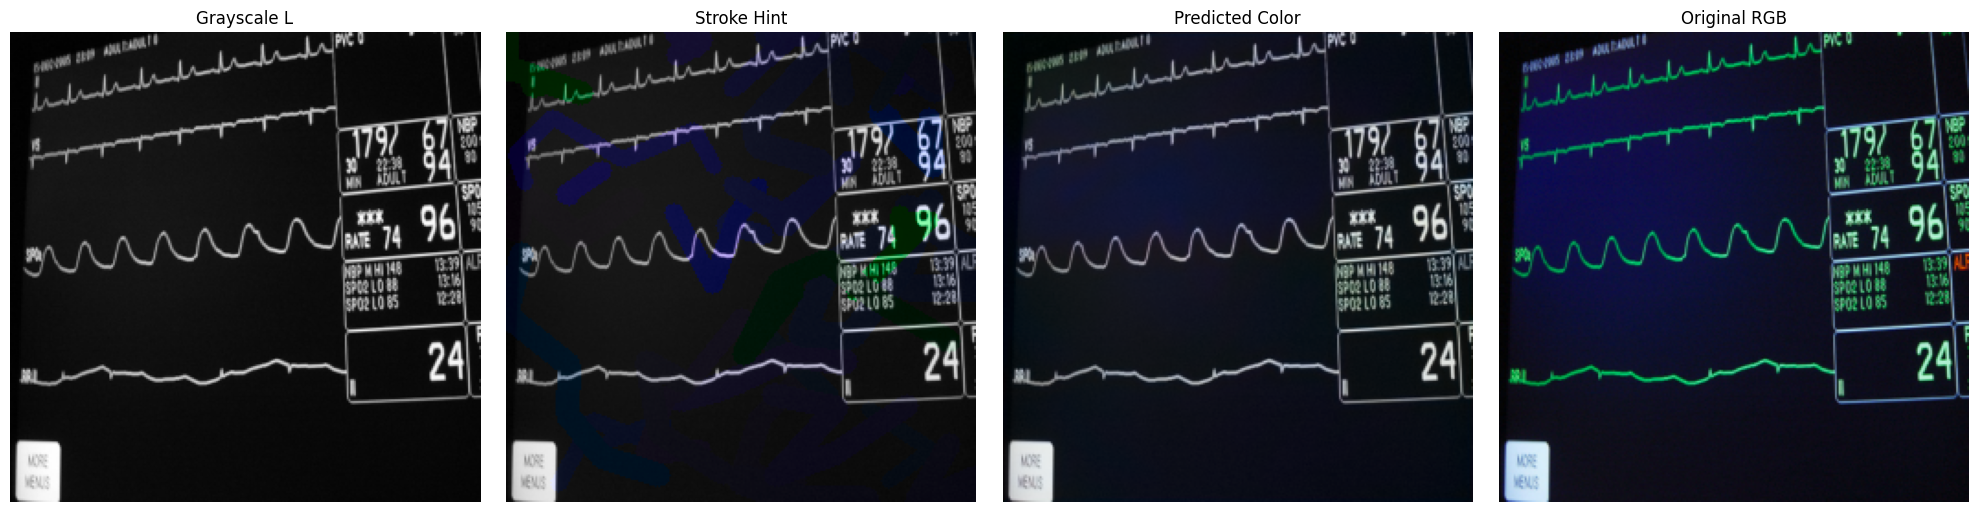

In [52]:
# Reuse the function from before
visualize_inference(model, test_dataset, index=0)
visualize_inference(model, test_dataset, index=1)
visualize_inference(model, test_dataset, index=2)
visualize_inference(model, test_dataset, index=3)

